Training set shape: (33199, 15)
Test set shape: (8300, 15)


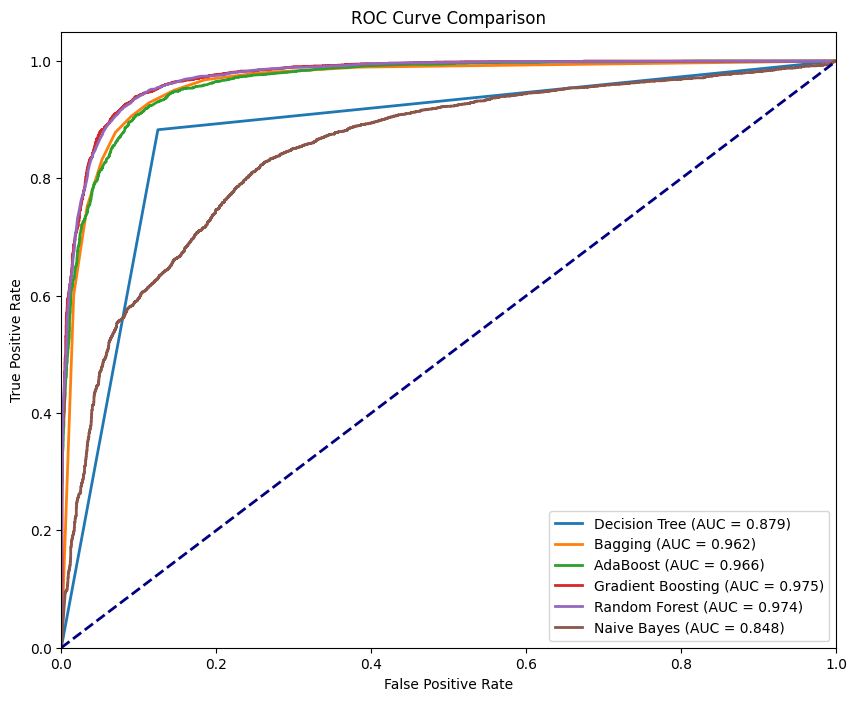

Decision Tree: AUC - ROC = 0.879
Bagging: AUC - ROC = 0.962
AdaBoost: AUC - ROC = 0.966
Gradient Boosting: AUC - ROC = 0.975
Random Forest: AUC - ROC = 0.974
Naive Bayes: AUC - ROC = 0.848

=======================Decision Tree:====================
TP Rate: 0.8829
FP Rate: 0.1246
F-mesure: 0.8866
AUC - ROC Score: 0.8791

=======================Bagging:====================
TP Rate: 0.9062
FP Rate: 0.0905
F-mesure: 0.9130
AUC - ROC Score: 0.9620

=======================AdaBoost:====================
TP Rate: 0.9141
FP Rate: 0.1052
F-mesure: 0.9114
AUC - ROC Score: 0.9656

=======================Gradient Boosting:====================
TP Rate: 0.9353
FP Rate: 0.0934
F-mesure: 0.9275
AUC - ROC Score: 0.9745

=======================Random Forest:====================
TP Rate: 0.9350
FP Rate: 0.0939
F-mesure: 0.9272
AUC - ROC Score: 0.9741

=======================Naive Bayes:====================
TP Rate: 0.2903
FP Rate: 0.0284
F-mesure: 0.4415
AUC - ROC Score: 0.8482


In [2]:
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import jupyter_black

jupyter_black.load()


def setup_visualization_style():
    """Set up the visualization style for plots."""
    # Color Palette
    custom_colors = ["#7400ff", "#a788e4", "#d216d2", "#ffb500", "#36c9dd"]
    sns.palplot(sns.color_palette(custom_colors))

    # Set Style
    sns.set_style("darkgrid")
    sns.despine(left=True, bottom=True)

    # Set tick size
    plt.rc("xtick", labelsize=12)
    plt.rc("ytick", labelsize=12)


def feature_selection_and_normalization(df):
    """
    Perform feature selection and normalization on the dataset.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data to be normalized and the class label.

    Returns:
    tuple: Processed training and testing datasets (X_train, X_test, y_train, y_test).
    """
    # Replace infinite values with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Split features (X) and target (y)
    X = df.drop("Class", axis=1)
    y = df["Class"]

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Create pipeline for imputing missing values and normalizing data
    pipeline = Pipeline(
        [
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler()),
        ]
    )

    # Apply pipeline to training and test data
    X_train = pd.DataFrame(
        columns=X_train.columns, data=pipeline.fit_transform(X_train)
    )
    X_test = pd.DataFrame(columns=X_test.columns, data=pipeline.transform(X_test))

    return X_train, X_test, y_train, y_test


def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance using various metrics.

    Parameters:
    model: Trained classifier model
    X_test (pd.DataFrame): Test features
    y_test (pd.Series): Test labels

    Returns:
    dict: Dictionary containing evaluation metrics
    """
    y_pred = model.predict(X_test)
    y_pred_proba = (
        model.predict_proba(X_test)[:, 1]
        if hasattr(model, "predict_proba")
        else model.decision_function(X_test)
    )

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    f_measure = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    return {
        "TP Rate": tp_rate,
        "FP Rate": fp_rate,
        "F-mesure": f_measure,
        "AUC - ROC Score": auc,
    }


def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple classification models, and plot ROC curves.

    Parameters:
    X_train, X_test, y_train, y_test: Training and test datasets

    Returns:
    dict: Dictionary containing results for each model
    """
    models = {
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Bagging": BaggingClassifier(),
        "AdaBoost": AdaBoostClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Naive Bayes": GaussianNB(),
    }

    results = {}
    roc_auc_scores = {}

    # Plot the ROC curves
    plt.figure(figsize=(10, 8))

    for name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)

        # Predict the probabilities
        y_probs = model.predict_proba(X_test)[:, 1]

        # Calculate the AUC - ROC score
        roc_auc = roc_auc_score(y_test, y_probs)
        roc_auc_scores[name] = roc_auc

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_probs)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

        # Evaluate the model and store the results
        results[name] = evaluate_model(model, X_test, y_test)

    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.show()

    # Print the AUC - ROC scores for each model
    for name, score in roc_auc_scores.items():
        print(f"{name}: AUC - ROC = {score:.3f}")

    return results


def display_results(results):
    """
    Display evaluation results for all models.

    Parameters:
    results (dict): Dictionary containing results for each model
    """
    for model_name, metrics in results.items():
        print(f"\n======================={model_name}:====================")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")


def main():
    """Main function to orchestrate the model evaluation process."""
    # Load data
    df = pd.read_csv("combine_datasets.csv")

    # Setup visualization style
    # setup_visualization_style()

    # Preprocess data
    X_train, X_test, y_train, y_test = feature_selection_and_normalization(df)
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")

    # Train and evaluate models
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

    # Display results
    display_results(results)


if __name__ == "__main__":
    main()